In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
import sys
from contextlib import redirect_stdout

import pandas as pd
from datetime import datetime
from tqdm import tqdm
import openai
import json
from collections import defaultdict, OrderedDict
from src.config import LLMTransformationConfig

config = LLMTransformationConfig()

class RelationExtractorEvaluator:
    """Evaluate the performance of a relation extraction model on a test dataset.
    
    Attributes:
        model (str): Model name to use for inference.
        openai_api (str): Base API URL for the OpenAI model.
        api_key (str): API key for accessing the model.
    """

    def __init__(self):
        self.api_key = "EMPTY"
        self.api_base = "http://localhost:8000/v1"
        self.model = "vicuna-7b-v1.1"
        # Initialize OpenAI
        openai.api_key = self.api_key
        openai.api_base = self.api_base

    @staticmethod
    def _calculate_metrics_for_entry(true_labels, predicted_labels):
        """Calculate precision, recall, and F1 score for a given set of true and predicted labels."""
        if not true_labels and not predicted_labels:  # If both are empty
            return 1, 1, 1

        if not true_labels or not predicted_labels:  # If one of them is empty
            return 0, 0, 0

        true_set = set(true_labels)
        predicted_set = set(predicted_labels)

        tp = len(true_set & predicted_set)
        fp = len(predicted_set - true_set)
        fn = len(true_set - predicted_set)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return precision, recall, f1

    def infer_from_model(self, dialogue, preprompt="", max_output_length=512):
        """Perform model inference given a dialogue and preprompt."""
        completion = openai.ChatCompletion.create(
            model=self.model,
            temperature=0,
            max_tokens=max_output_length,  # Set your desired max length
            messages=[{
                "role": "user",
                "content": preprompt + dialogue
            }]
        )
        return completion.choices[0].message.content

    def assess_performance_on_test_dataset(self, test_file_path, cap_size=None, return_details=False, remove_ordereddict=True):
        """Evaluate the model's performance on the provided test dataset."""
        with open(test_file_path, 'r', encoding='utf8') as fp:
            test_data = json.load(fp)

        if cap_size:
            test_data = test_data[:cap_size]

        details = []
        results_per_class = defaultdict(list)
        pbar = tqdm(test_data, dynamic_ncols=True, leave=False, position=0)

        overall_predictions = []
        overall_true = []

        result_df = pd.DataFrame(columns=["id","prompt","dialogue","true_labels","raw_inference","predicted_labels","correct_labels","wrong_labels","f1s","precision","recall","error_message"])
        errors = []
        
        total_precision, total_recall, total_f1 = 0, 0, 0
        processed_entries = 0
        errors_count = 0


        for entry in pbar:
            precision = None 
            recall = None 
            f1 = None
            dialogue = None
            true_labels = None
            raw_inference = None
            predicted_labels = None
            correct_labels = None
            wrong_labels = None
            
            prompt = "\n".join([message["value"] for message in entry["conversations"] if message["from"] == "human"])
            try:
                raw_inference = self.infer_from_model(prompt)
                predicted_relations = json.loads(raw_inference, object_pairs_hook=OrderedDict) if not raw_inference in ['', '\n'] else []
                true_relations = json.loads(entry["conversations"][1]["value"], object_pairs_hook=OrderedDict)

                predicted_labels = [str(pred_relation) for pred_relation in predicted_relations]
                true_labels = [str(true_relation) for true_relation in true_relations]

                for true_relation in true_relations:
                    results_per_class[true_relation.get('r')].append((predicted_labels, true_labels))

                precision, recall, f1 = self._calculate_metrics_for_entry(true_labels, predicted_labels)

                total_precision += precision
                total_recall += recall
                total_f1 += f1
                processed_entries += 1

                overall_predictions.extend(predicted_labels)
                overall_true.extend(true_labels)

                avg_precision = total_precision / processed_entries
                avg_recall = total_recall / processed_entries
                avg_f1 = total_f1 / processed_entries
        
                pbar.set_description(f"Avg P: {avg_precision:.1%} | Avg R: {avg_recall:.1%} | Avg F1: {avg_f1:.1%} | Errors: {errors_count}/{len(test_data)} ({errors_count/len(test_data):.0%})")

                # Calculate correct and wrong labels
                correct_labels = list(set(true_labels) & set(predicted_labels))
                wrong_labels = list(set(predicted_labels) - set(true_labels))
                
                dialogue = prompt.split('Input:')[-1].replace('Output:','')

                if return_details:
                    detail = {
                        "id": entry['id'],
                        "prompt": prompt.replace(config.preprompt, ''),
                        "dialogue": dialogue,
                        "true_labels": true_labels,
                        "raw_inference": raw_inference,
                        "predicted_labels": predicted_labels,
                        "correct_labels": correct_labels,
                        "wrong_labels": wrong_labels,
                        "f1s": f1,
                        "precision": precision,
                        "recall": recall,
                        "error_message": ''

                    }
                    details.append(detail)
                    result_df.loc[len(result_df.index)] = detail
    

            except Exception as e:
                errors_count += 1

                errors.append(f"{entry['id']}: {e}")
                                            
                def get_value_from_locals(var_name, local_vars, transform_func=str, default_value=None):
                    value = local_vars.get(var_name, default_value)
                    if isinstance(value, (list, tuple)):
                        return [transform_func(item) for item in value]
                    return value

                local_vars = locals()  # Capture local variables where the function will be called

                # Inside your loop
                error_detail = {
                    "id": entry['id'],
                    "prompt": get_value_from_locals('prompt', local_vars),
                    "dialogue": get_value_from_locals('dialogue', local_vars),
                    "true_labels": get_value_from_locals('true_relations', local_vars),
                    "raw_inference": get_value_from_locals('raw_inference', local_vars),
                    "predicted_labels": get_value_from_locals('predicted_relations', local_vars),
                    "correct_labels": get_value_from_locals('correct_labels', local_vars),
                    "wrong_labels": get_value_from_locals('wrong_labels', local_vars),
                    "f1s": get_value_from_locals('f1', local_vars, default_value=0),
                    "precision": get_value_from_locals('precision', local_vars, default_value=0),
                    "recall": get_value_from_locals('recall', local_vars, default_value=0),
                    "error_message": str(e)
                }

                result_df.loc[len(result_df.index)] = error_detail
                


        output_path = test_file_path.replace('.json', '')
        current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        if remove_ordereddict:
            for col in result_df.columns:
                if 'labels' in col:
                    result_df[col] = result_df[col].apply(lambda x: [xi.replace('OrderedDict', '') for xi in x] if x is not None else None)

                
        output_path = f"{output_path}_{current_time}.xlsx"
        result_df.to_excel(output_path, index=False)
        print(f"\nScript successfully executed!")
        print(f"Avg P: {avg_precision:.1%} | Avg R: {avg_recall:.1%} | Avg F1: {avg_f1:.1%} | Errors: {errors_count}/{len(test_data)} ({errors_count/len(test_data):.0%})")
        print(f"# INFERENCE REPORT\n{output_path}\n")

            
        overall_precision, overall_recall, overall_f1 = self._calculate_metrics_for_entry(overall_true, overall_predictions)

        per_class_results = {}
        for relation, labels_list in results_per_class.items():
            preds, trues = [], []
            for preds_labels, true_labels in labels_list:
                preds.extend(preds_labels)
                trues.extend(true_labels)

            precision, recall, f1 = self._calculate_metrics_for_entry(trues, preds)

            per_class_results[relation] = {
                "precision": precision,
                "recall": recall,
                "f1": f1
            }

        result = {
            "overall": {
                "precision": overall_precision,
                "recall": overall_recall,
                "f1": overall_f1
            },
            "per_class": per_class_results
        }

        if return_details:
            result["details"] = details

        return result_df

class FileManager:
    """Handle reading and writing of files."""
    
    @staticmethod
    def read_json_file(file_path):
        """Read a JSON file and return its content."""
        with open(file_path, 'r', encoding='utf8') as fp:
            return json.load(fp)
    
    # Any other file-related functions can be added here

evaluator = RelationExtractorEvaluator()

# Define path for the test dataset
data_stem="dialog-re-llama-11cls-2spkr-balPairs"
test_file_path = f"/home/murilo/RelNetCare/data/processed/{data_stem}/{data_stem}-test.json"

# Evaluate performance
df = evaluator.assess_performance_on_test_dataset(test_file_path, cap_size=None, return_details=True)
# print(results['overall'])

output_dir= /home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-balPairs



Script successfully executed!
Avg P: 41.3% | Avg R: 42.1% | Avg F1: 41.5% | Errors: 3/66 (5%)
# INFERENCE REPORT
/home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-2spkr-balPairs/dialog-re-llama-11cls-2spkr-balPairs-test_20230830_132613.xlsx



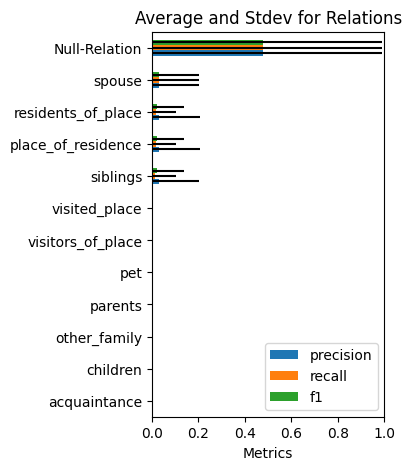

In [120]:
import pandas as pd
import matplotlib.pyplot as plt

your_ontology =  {
    "other_family", "siblings",
    "visited_place",
    "place_of_residence",
    "spouse", 
    "pet", "acquaintance", "children", "visitors_of_place", "residents_of_place", "parents"
    }

grouped = df.groupby('id')

def aggregate_by_relation(group):
    metrics_by_relation = {}

    all_true_labels = any(group['true_labels'])
    all_predicted_labels = any(group['raw_inference'])

    if not all_true_labels and not all_predicted_labels:
        metrics_by_relation["Null-Relation"] = {'precision': 1, 'recall': 1, 'f1': 1}
    elif all_true_labels and not all_predicted_labels:
        metrics_by_relation["Null-Relation"] = {'precision': 0, 'recall': 0, 'f1': 0}
    
    for r in your_ontology:
        true_labels = [str(x) for x in group['true_labels'].iloc[0] if True]
        predicted_labels = [str(x) for x in group['predicted_labels'].iloc[0] if r in x]
        

        if not true_labels and not predicted_labels:  
           metrics_by_relation[r] = {'precision': None, 'recall': None, 'f1': None}
        else:
            precision, recall, f1 = RelationExtractorEvaluator._calculate_metrics_for_entry(true_labels, predicted_labels)
            metrics_by_relation[r] = {'precision': precision, 'recall': recall, 'f1': f1}
        

    return metrics_by_relation


result = {}
for name, group in grouped:
    # print(name, group)
    result[name] = aggregate_by_relation(group)


# Convert your result dict to DataFrame
chart_df = pd.DataFrame.from_dict({(i, j): result[i][j] 
                            for i in result.keys() 
                            for j in result[i].keys()}, 
                            orient='index')

# Drop None values
# chart_df = chart_df.dropna()

# Aggregate metrics for each relation
agg_stats = chart_df.groupby(level=1).agg(['mean', 'std'])

# Plot
fig, ax = plt.subplots()


agg_stats = agg_stats.sort_values(by=('f1', 'mean'), ascending=True)
agg_stats.xs('mean', axis=1, level=1).plot(kind='barh', xerr=agg_stats.xs('std', axis=1, level=1), ax=ax, figsize=(3,5))
plt.xlabel('Metrics')
plt.title('Average and Stdev for Relations')
plt.xlim(0, 1)  # Set x-axis limits between 0 and 1
plt.legend(loc='lower right')  # Set legend position
plt.show()


In [105]:
group['true_labels'].iloc[0][0]

"([('x', 'Speaker 2'), ('x_type', 'PER'), ('r', 'siblings'), ('y', 'Ursula'), ('y_type', 'PER')])"

In [67]:
'siblings' in str(group['true_labels'].iloc[0])

True

In [29]:
# infer_from_model('Alice: Hi, you are my father.\nRobert: Yes, I am your father', preprompt=preprompt)
dialogue = 'Alice: Hi, you are my father.\nRobert: Yes, I am your father'
# dialogue = 'Alice: I went to Maryland.\nRobert: Why?\nAlice: I work at Google there.'
# dialogue = 'Alice: I love my husband.\nRobert: Sweet! What is his name?\nAlice: John.'
# dialogue = 'Alice: I love my husband.\nRobert: Sweet! '
jsonl = evaluator.infer_from_model(dialogue, preprompt=config.preprompt)
print(dialogue)

try:
    print(jsonl.replace('},', '},\n'))
except Exception as e:
    print(f'Exception={e}')
    print(jsonl)

Alice: Hi, you are my father.
Robert: Yes, I am your father
[{""visitors_of_place"": "place", ""place"": "place", ""other_family"": "other", ""parents"": "other", ""siblings"": "other", ""spouse"": "other", ""visited_place"": "place", ""acquaintance"": "other"}]


In [178]:
json.dumps(json.loads(jsonl), indent=4)

'[\n    {\n        "x": "John",\n        "x_type": "PER",\n        "r": "spouse",\n        "y": "Alice",\n        "y_type": "PER"\n    },\n    {\n        "x": "Alice",\n        "x_type": "PER",\n        "r": "spouse",\n        "y": "John",\n        "y_type": "PER"\n    }\n]'


Extract personal relevant entities, and their relations. Return only the jsonl format list .

Ontology: 
- relations: {"parents", "pet", "other_family", "place_of_residence", "acquaintance", "visitors_of_place", "visited_place", "residents_of_place", "children", "spouse", "siblings"}
- types: {"ORG", "GPE", "PERSON", "DATE", "EVENT", “ANIMAL”}

Input:



In [152]:
import pandas as pd
df = pd.DataFrame(results['details'])
print(json.dumps(df.sort_values('f1').iloc[0].to_dict(), indent=4))
# df.sort_values('f1').iloc[0].to_dict()

{
    "id": "identity_0",
    "prompt": "\nExtract personal relevant entities, and their relations. Return only the jsonl format list .\n\nOntology: \n- relations: {\"other_family\", \"siblings\", \"visited_place\", \"place_of_residence\", \"spouse\", \"pet\", \"acquaintance\", \"children\", \"visitors_of_place\", \"residents_of_place\", \"parents\"}\n- types: {\"ORG\", \"GPE\", \"PERSON\", \"DATE\", \"EVENT\", \u201cANIMAL\u201d}\n\nInput:\nSpeaker 1: Hi, Ursula.\nSpeaker 2: Hey!\nSpeaker 1: Okay, well umm, I know that we haven\u2019t talked in a long time, but umm okay, our Mom is not our birth Mom. This-this other lady is our birth Mom.\nSpeaker 2: Right, okay, the one that lives in Montuak, umm-hmm.\nSpeaker 1: You know her?!\nSpeaker 2: No, I umm, I read about her in Mom\u2019s suicide note.\nSpeaker 1: There-there was a suicide note?! Well, do you still have it?\nSpeaker 2: Hang on.\nSpeaker 1: I can\u2019t believe you didn\u2019t tell me there was a suicide note!\nSpeaker 2: Yea

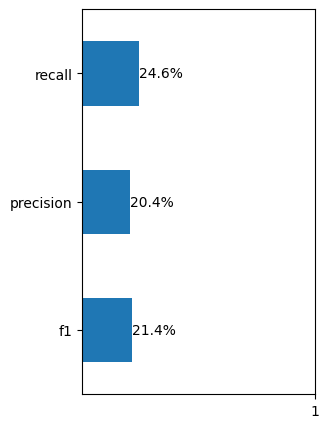

In [153]:
import matplotlib.pyplot as plt

# Your plotting code here
ax = df[['f1', 'precision', 'recall']].mean().plot(kind='barh', alpha=1, figsize=(3, 5))

# Set x-axis tick labels
plt.xticks([1], ['1'])

# Adding data values on top of each bar
for bar in ax.patches:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.1%}', 
             va='center', ha='left')

# Show the plot
plt.show()


<Axes: ylabel='Frequency'>

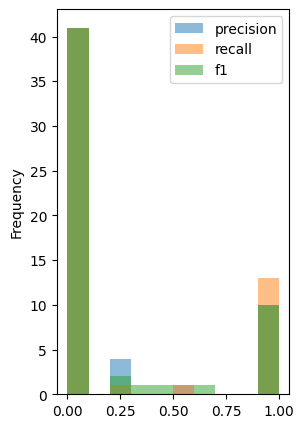

In [154]:
df[['precision', 'recall', 'f1']].plot(kind='hist', alpha=0.5, figsize=(3, 5))


([<matplotlib.axis.XTick at 0x7ff9a4d33bb0>], [Text(1, 0, '1')])

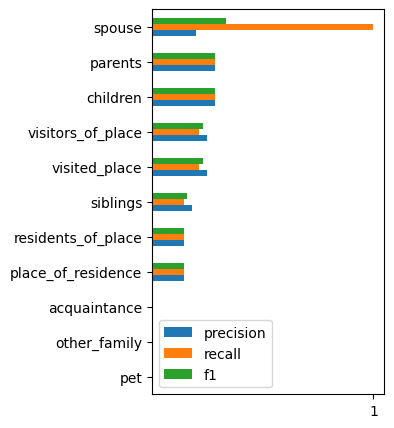

In [155]:
ax = pd.DataFrame(results['per_class']).T.sort_values('f1', ascending=True).plot(kind='barh', figsize=(3, 5))

# Set x-axis tick labels
plt.xticks([1], ['1'])




In [156]:
df['prompt_length'] = df.prompt.apply(len)

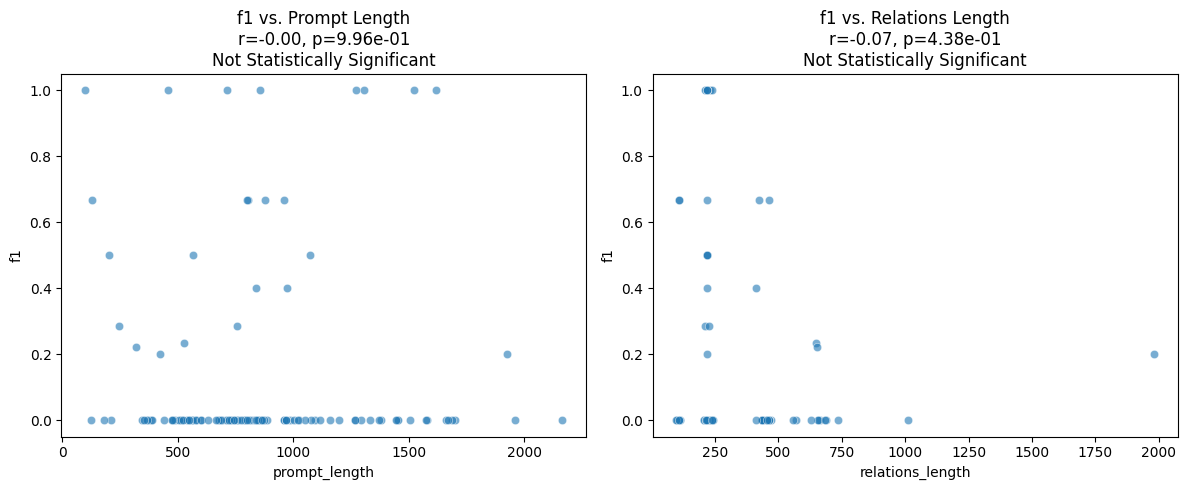

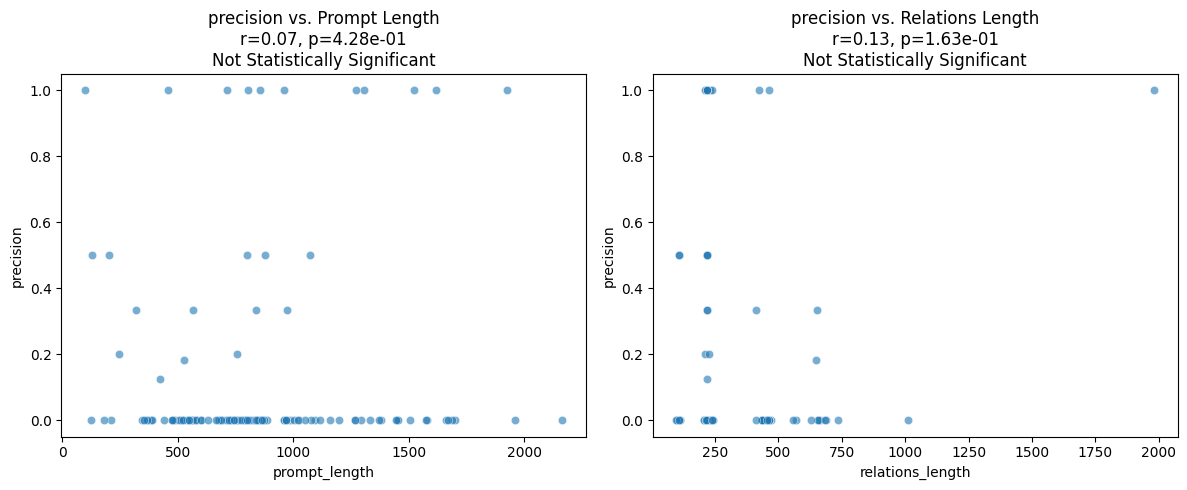

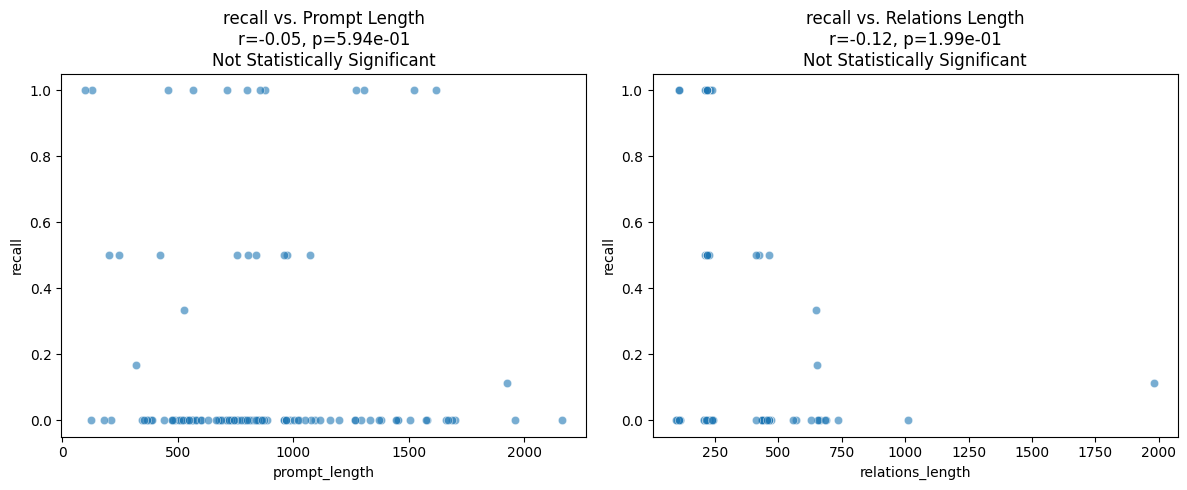

In [22]:
# Compute the metrics correlation with length
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming your dataframe is named df
# Calculate the length of relations for each row
df['relations_length'] = df['true_relations'].apply(lambda x: sum([len(str(relation)) for relation in x]))

# Plotting correlation between prompt length and metrics
metrics = ['f1', 'precision', 'recall']

for metric in metrics:
    plt.figure(figsize=(12, 5))
    
    # Plot for prompt length
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df, x='prompt_length', y=metric, alpha=0.6)
    corr_coef, p_value = pearsonr(df['prompt_length'], df[metric])
    significance = "Statistically Significant" if p_value < 0.05 else "Not Statistically Significant"
    plt.title(f'{metric} vs. Prompt Length\nr={corr_coef:.2f}, p={p_value:.2e}\n{significance}')

    # Plot for relations length
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=df, x='relations_length', y=metric, alpha=0.6)
    corr_coef, p_value = pearsonr(df['relations_length'], df[metric])
    significance = "Statistically Significant" if p_value < 0.05 else "Not Statistically Significant"
    plt.title(f'{metric} vs. Relations Length\nr={corr_coef:.2f}, p={p_value:.2e}\n{significance}')

    plt.tight_layout()
    plt.show()


In [23]:
import pandas as pd

# Sort the dataframe by 'f1'
df = df.sort_values('f1')
mask = df.prompt_length < 350
tmp = df[mask]

# Calculate the quartile boundaries
q3 = tmp['f1'].quantile(0.75)

# Select one example from each quartile
example_1 = tmp[df['f1'] <= 0].sample(1)
example_2 = tmp[(df['f1'] > 0) & (df['f1'] <= .45)].sample(1)
example_3 = tmp[(df['f1'] > .25)].sample(1)

# Concatenate the examples to get a dataframe of examples from each quartile
exemplary_samples = pd.concat([example_1, example_2, example_3, example_4])

exemplary_samples


/tmp/ipykernel_203525/2882830022.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  example_1 = tmp[df['f1'] <= 0].sample(1)
/tmp/ipykernel_203525/2882830022.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  example_2 = tmp[(df['f1'] > 0) & (df['f1'] <= .45)].sample(1)
/tmp/ipykernel_203525/2882830022.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  example_3 = tmp[(df['f1'] > .25)].sample(1)


NameError: name 'example_4' is not defined

In [ ]:
def format_relations(relations):
    formatted_relations = []
    for relation in relations:
        try:
            formatted_relations.append({
                "x": relation['x'],
                "x_type": "PERSON",  # Assuming all are persons, you can adjust based on your dataset
                "y": relation['y'],
                "y_type": "PERSON",  # Assuming all are persons, you can adjust based on your dataset
                "r": relation['r']
            })
        except KeyError as e:
            print(f"KeyError: {e}. Problematic relation: {relation}")
    return formatted_relations


def convert_to_new_format(sample, relations='predicted_relations'):
    dialog = []
    
    # Split prompt into sentences and format them
    for line in sample['prompt'].split("\n"):
        speaker, content = line.split(": ", 1)
        dialog.append(f"{speaker}: {content}")
    
    # Format relations
    formatted_relations = format_relations(sample[relations])
    
    return [dialog, formatted_relations]

# Loop through all samples and convert them to the desired format
all_formatted_data = [convert_to_new_format(row.to_dict(), 
                                            # relations='true_relations'
                                            ) for _, row in exemplary_samples.iterrows()]

json.dumps(all_formatted_data)


'[[["Speaker 1: So, thanks for having me over! Rach. Pheebs.", "Speaker 2: See ya!! What the hell was that?!", "Speaker 3: Probably some y\'know, European good-bye thing he picked up in London.", "Speaker 4: That\'s not European!", "Speaker 5: Well, it felt French."], [{"x": "Speaker 1", "x_type": "PERSON", "y": "Pheebs", "y_type": "PERSON", "r": "visitors"}, {"x": "Pheebs", "x_type": "PERSON", "y": "Speaker 1", "y_type": "PERSON", "r": "visitors"}]], [["Speaker 1: Kids, I spoke to a doctor and picked up this pamphlets on how to get pregnant.", "Speaker 2: Hey dad!", "Speaker 3: Hey.", "Speaker 1: Sorry to bother you again, but could you pass my pamphlets back? Thank you."], [{"x": "Speaker 1", "x_type": "PERSON", "y": "Speaker 2", "y_type": "PERSON", "r": "parents"}, {"x": "Speaker 1", "x_type": "PERSON", "y": "Speaker 3", "y_type": "PERSON", "r": "children"}, {"x": "Speaker 3", "x_type": "PERSON", "y": "Speaker 1", "y_type": "PERSON", "r": "parents"}, {"x": "Speaker 2", "x_type": "PE

ModuleNotFoundError: No module named 'src'

In [8]:
infer_from_model('Alice: Hi, you are my father.\nRobert: Yes, I am your father', preprompt=preprompt)

'[{"x": "Alice", "x_type": "PER", "r": "parents", "y": "Robert", "y_type": "PER"}, {"x": "Alice", "x_type": "PER", "r": "children", "y": "Robert", "y_type": "PER"}]'

In [ ]:
infer_from_model('Alice: I went to Maryland.\nRobert: Why?\nAlice: I work at Google there.', preprompt=preprompt)

'[{"x": "Alice", "x_type": "PER", "r": "parents", "y": "Robert", "y_type": "PER"}, {"x": "Alice", "x_type": "PER", "r": "children", "y": "Robert", "y_type": "PER"}]'